# <a id='toc1_'></a>[UCRB PET Analysis](#toc0_)
Author: Daniel Hogan

Created: September 7, 2023

This notebook will take in temperature data from PRISM and calculate PET using the Thornthwaite equation. It will then compare these reults to another PET product from TerraClimate. A section is devoted to exploring PET from a 1-km WRF run over 2 HCDN basins between 1987-2020 but that data will not be available here (a link to the dataset is provided below). Lastly, we compare the spring temperature/precipitation relationship to the trend in temperature to see which is greater. 

**Table of contents**<a id='toc0_'></a>    
- [UCRB PET Analysis](#toc1_)    
    - [Imports](#toc1_1_1_)    
- [Pull in boundary data](#toc2_)    
- [Pull in Terraclime data](#toc3_)    
    - [Set boundary to the UCRB](#toc3_1_1_)    
    - [TerraClimate Spring PET, PPT, and Temp](#toc3_1_2_)    
    - [Correlation for TerraClimate PET](#toc3_1_3_)    
- [Pull in the PRISM Data to Estimate PET](#toc4_)    
    - [PRISM UCRB Precipitation](#toc4_1_1_)    
    - [PRISM UCRB Temperature](#toc4_1_2_)    
    - [PRISM UCRB Thornthwaite Estimate](#toc4_1_3_)    
- [Spearman correlation figure between spring precipitation and PET](#toc5_)    
- [Plot PET against Spring P colored by Tmean](#toc6_)    
    - [Assessing temporal trend in temperature vs. spring preciptiation relationship](#toc6_1_1_)    
    - [Assessing temporal trend in PET vs. spring precipitation relationship](#toc6_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [1]:
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
# from pyeto import fao
import numpy as np
from scipy.stats.stats import pearsonr, spearmanr
import scipy.stats as stats
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad


/tmp/ipykernel_889/3014695817.py:11: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr
/tmp/ipykernel_889/3014695817.py:11: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr


# <a id='toc2_'></a>[Pull in boundary data](#toc0_)

In [2]:
# LCC projection for the Upper Colorado River Basin
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" 

# Read in the UCRB boundary
ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary_4326 = ucrb_boundary.copy()
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj) # reprojection to LCC

# Read in the HCDN boundaries
hcdn_boundaries = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_boundaries=hcdn_boundaries.set_crs(epsg=32613,allow_override=True)
hcdn_boundaries_4326=hcdn_boundaries.to_crs(4326) # reprojection to 4326


# <a id='toc3_'></a>[Pull in Terraclime data](#toc0_)

Terraclimate data between 1958 and 2022 was downloaded from https://www.climatologylab.org/terraclimate.html

In [3]:
terraclimate_pet = xr.open_dataset('../data/etdata/agg_terraclimate_pet_1958_CurrentYear_GLOBE.nc')
terraclimate_ppt = xr.open_dataset('../data/precipdata/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc')
terraclimate_tmin = xr.open_dataset('../data/etdata/agg_terraclimate_tmin_1958_CurrentYear_GLOBE.nc')
terraclimate_tmax = xr.open_dataset('../data/etdata/agg_terraclimate_tmax_1958_CurrentYear_GLOBE.nc')
# resample to daily data
# terraclimate_pet_daily = terraclimate_pet.resample(time='1D').interpolate('cubic')
# convert to a raster and change crs to match the UCRB boundary
terraclimate_pet = terraclimate_pet.rio.write_crs(4326)
terraclimate_ppt = terraclimate_ppt.rio.write_crs(4326)
terraclimate_tmin = terraclimate_tmin.rio.write_crs(4326)
terraclimate_tmax = terraclimate_tmax.rio.write_crs(4326)

### <a id='toc3_1_1_'></a>[Set boundary to the UCRB](#toc0_)

In [4]:
pet_ucrb = terraclimate_pet.rio.clip(ucrb_boundary_4326.geometry).sel(time=slice('1964-1-1','2022-9-30'))
ppt_ucrb = terraclimate_ppt.rio.clip(ucrb_boundary_4326.geometry).sel(time=slice('1964-1-1','2022-9-30'))
tmin_ucrb = terraclimate_tmin.rio.clip(ucrb_boundary_4326.geometry).sel(time=slice('1964-1-1','2022-9-30'))
tmax_ucrb = terraclimate_tmax.rio.clip(ucrb_boundary_4326.geometry).sel(time=slice('1964-1-1','2022-9-30'))

In [5]:
tmean_ucrb = (tmax_ucrb.tmax + tmin_ucrb.tmin)/2
tdiff_ucrb = tmax_ucrb.tmax - tmin_ucrb.tmin

### <a id='toc3_1_2_'></a>[TerraClimate Spring PET, PPT, and Temp](#toc0_)

In [6]:
# TerraClimate PET and PPT for the UCRB
ucrb_spring_totals_terraclime_pet = pet_ucrb['pet'].where(pet_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time')
ucrb_spring_totals_terraclime_ppt = ppt_ucrb['ppt'].where(ppt_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time')

# TerraClimate TMIN and TMAX for the UCRB
ucrb_spring_tmin_terraclime = tmin_ucrb.tmin.where(tmin_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time')
ucrb_spring_tmax_terraclime = tmax_ucrb.tmax.where(tmax_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time')
# TerraClimate TMEAN and TDIFF for the UCRB
ucrb_spring_tmean_terraclime = (tmean_ucrb.where(tmean_ucrb.time.dt.month.isin([4,5,6]))).groupby('time.year').mean('time')
ucrb_spring_tdiff_terraclime = tdiff_ucrb.where(tdiff_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time')
# TerraClimate temperature anomaly for the UCRB
ucrb_spring_tmean_terraclime_anomaly = ucrb_spring_tmean_terraclime - ucrb_spring_tmean_terraclime.mean('year')


In [7]:
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)

### <a id='toc3_1_3_'></a>[Correlation for TerraClimate PET](#toc0_)

In [8]:
corr_terraclimate = multi_apply_along_axis(pearsonr, 0, [ucrb_spring_totals_terraclime_pet, ucrb_spring_totals_terraclime_ppt])
# convert to an xarray dataarray
corr_terraclimate = xr.DataArray(corr_terraclimate[0,:,:], dims=['lat','lon'], coords={'lat':ucrb_spring_totals_terraclime_pet.lat,'lon':ucrb_spring_totals_terraclime_pet.lon})
corr_terraclimate = corr_terraclimate.rio.set_crs(4326)
# convert to 32613
corr_terraclimate = corr_terraclimate.rio.reproject(32613)
# remove values above 1
corr_terraclimate = corr_terraclimate.where(corr_terraclimate<=1,drop=True)

/home/dlhogan/miniforge3/envs/ucrb_analysis_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [9]:
corr_terraclimate_temp = multi_apply_along_axis(pearsonr, 0, [ucrb_spring_tmean_terraclime, ucrb_spring_totals_terraclime_ppt])
# convert to an xarray dataarray
corr_terraclimate_temp = xr.DataArray(corr_terraclimate_temp[0,:,:], dims=['lat','lon'], coords={'lat':ucrb_spring_totals_terraclime_ppt.lat,'lon':ucrb_spring_totals_terraclime_ppt.lon})
corr_terraclimate_temp = corr_terraclimate_temp.rio.set_crs(4326)
# convert to 32613
corr_terraclimate_temp = corr_terraclimate_temp.rio.reproject(32613)
# remove values above 1
corr_terraclimate_temp = corr_terraclimate_temp.where(corr_terraclimate_temp<=1,drop=True)

/home/dlhogan/miniforge3/envs/ucrb_analysis_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


# <a id='toc4_'></a>[Pull in the PRISM Data to Estimate PET](#toc0_)

### <a id='toc4_1_1_'></a>[PRISM UCRB Precipitation](#toc0_)

In [10]:
# Open PRISM precipitation data
prism_ppt = rxr.open_rasterio('../data/precipdata/prism_4km_ucrb.nc')
# convert crs to match the UCRB boundary
prism_ppt = prism_ppt.rio.reproject(4326)
prism_ppt = prism_ppt.where(prism_ppt>=0,drop=True)

In [11]:
# Get seasonal total precipitation for the UCRB over spring
ucrb_spring_ppt = prism_ppt.where(prism_ppt['month'].dt.month.isin([3,4,5]),drop=True).groupby('month.year').sum()
ucrb_spring_ppt = ucrb_spring_ppt.where(ucrb_spring_ppt>0,drop=True).sel(year=slice(1964,2022))

### <a id='toc4_1_2_'></a>[PRISM UCRB Temperature](#toc0_)

In [12]:
# Open PRISM temperature data
prism_tmean = rxr.open_rasterio('../data/etdata/prism_tmean_4km_ucrb.nc')
# reprject to match the UCRB boundary
prism_tmean = prism_tmean.rio.reproject(4326)
prism_tmean = prism_tmean.where(prism_tmean>-100,drop=True).sel(month=slice('1964-01-01','2022-09-30'))
spring_mean_ucrb_temp = prism_tmean.where(prism_tmean['month'].dt.month.isin([3,4,5]),drop=True).groupby('month.year').mean()
# calculate spring mean temperature anomaly
spring_mean_ucrb_temp_anomaly = spring_mean_ucrb_temp - spring_mean_ucrb_temp.mean('year')

In [13]:
# add the year as a new dimension to prism_tmean
prism_tmean = prism_tmean.assign_coords(year=prism_tmean['month'].dt.year)

# make a copy to use later
prism_tmean_copy = prism_tmean.copy()
prism_tmean_copy['month'] = prism_tmean_copy['month'].dt.year

### <a id='toc4_1_3_'></a>[PRISM UCRB Thornthwaite Estimate](#toc0_)

In [14]:
# for each latitutde, calculate the thornthwaite p
latitudes = np.deg2rad(prism_tmean.y)
# calculate the mean daylight hours for each month
mmdlh = np.vstack([monthly_mean_daylight_hours(lat, year=2018)*59 for lat in latitudes])

# convert mmdlh to xarray to match the time dimension of prism_tmean
mmdlh = xr.DataArray(mmdlh[:,3:], dims=['y','month'], coords={'y':prism_tmean.y,'month':prism_tmean_copy.month})


In [16]:
def vectorize_thornthwaite_pet(tmean, N, _MONTHDAYS):
    """
    Vectorized version of the Thornthwaite PET equation. Input arrays must have the same dimensions. 
    Can be used to estimate PET from monthly mean temperature from PRISM and monthly mean daylight hours from latitude.
    Time index must be in years (e.g. 1987, 1988, 1989, etc.) repeated over for the number of each year's months (e.g. 1987, 1987, 1987, etc.)
    Inputs:
        tmean: mean monthly temperature (deg C), dimensions (time, lat, lon)
        N: mean monthly daylight hours (hours), dimensions (time, lat)  
        _MONTHDAYS: number of days in each month (days), dimensions (time)
    Returns:
        pet: monthly PET (mm/month)

    """
    # Negative temperatures should be set to zero
    adj_monthly_t = tmean * (tmean >= 0)
    # create empty arrays to be filled
    I = xr.zeros_like(adj_monthly_t)
    alpha = xr.zeros_like(adj_monthly_t)
    pet = xr.zeros_like(adj_monthly_t)
    # Iterate through each year
    for year in tmean.month.to_series().unique():
        # calculate the heat index for each year 
        I.loc[year] += (adj_monthly_t.where(adj_monthly_t>0).sel(month=year) / 5.0) ** 1.514
        # calculate the alpha multiplier for each year
        alpha.loc[year] = (6.75e-07 * I.loc[year].sum(dim='month') ** 3) - (7.71e-05 * I.loc[year].sum(dim='month') ** 2) + (1.792e-02 * I.loc[year].sum(dim='month') + 0.49239)
        # estimate PET using the Thornthwaite equation for each year
        pet.loc[year] = 16*(N.sel(month=year).transpose()/12)*(_MONTHDAYS.sel(month=year)/30)*(10*adj_monthly_t.sel(month=year)/I.loc[year].sum(dim='month'))**alpha.loc[year]
    return pet

In [17]:
# Calculate pet for each year at each grid cell
tmean = prism_tmean_copy
_MONTHDAYS = xr.DataArray(np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]*59)[:-3], dims=['month'], coords={'month':prism_tmean_copy.month})
# pet = np.zeros_like(tmean)
ucrb_prism_pet = vectorize_thornthwaite_pet(prism_tmean_copy, mmdlh,_MONTHDAYS)
ucrb_prism_pet['month'] = prism_tmean.month
# calculate the sum of PET over each spring period
ucrb_spring_pet = ucrb_prism_pet.where(ucrb_prism_pet['month'].dt.month.isin([4,5,6]),drop=True).groupby('month.year').sum()
ucrb_spring_ppt = ucrb_spring_ppt.fillna(-9999)
ucrb_spring_pet = ucrb_spring_pet.fillna(-9999)

In [18]:
corr_prism = multi_apply_along_axis(pearsonr, 0, [ucrb_spring_ppt, ucrb_spring_pet])
# convert to an xarray dataarray
corr_prism = xr.DataArray(corr_prism[0,:,:], dims=['y','x'], coords={'y':ucrb_spring_ppt.y,'x':ucrb_spring_ppt.x})
corr_prism = corr_prism.rio.set_crs(4326)
# convert to 32613
corr_prism = corr_prism.rio.reproject(32613)
# remove values above 1
corr_prism = corr_prism.where(corr_prism<=1,drop=True)

/home/dlhogan/miniforge3/envs/ucrb_analysis_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [19]:
corr_prism_temp = multi_apply_along_axis(pearsonr, 0, [ucrb_spring_ppt, spring_mean_ucrb_temp])
# convert to an xarray dataarray
corr_prism_temp = xr.DataArray(corr_prism_temp[0,:,:], dims=['y','x'], coords={'y':ucrb_spring_ppt.y,'x':ucrb_spring_ppt.x})
corr_prism_temp = corr_prism_temp.rio.set_crs(4326)
# convert to 32613
corr_prism_temp = corr_prism_temp.rio.reproject(32613)
# remove values above 1
corr_prism_temp = corr_prism_temp.where(corr_prism_temp<=1,drop=True)

/home/dlhogan/miniforge3/envs/ucrb_analysis_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


# <a id='toc5_'></a>[Spearman correlation figure between spring precipitation and PET](#toc0_)

In [20]:
src_4km = rxr.open_rasterio('../data/geodata/ucrb_dem_32613_150m.tif')
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)
# downsample to 800m
src_4km = src_4km.rio.reproject(dst_crs='EPSG:32613', resolution=3945.843241747955)
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)

dx, dy =3945.843241747955,3945.843241747955

ucrb_boundary_32613 = ucrb_boundary_4326.to_crs(32613)
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth

ucrb_stream_traces = gpd.read_file('../data/geodata/Colorado_River_Basin_Rivers.geojson')
ucrb_stream_traces = ucrb_stream_traces.to_crs(32613)
# clip to UCRB boundary
ucrb_stream_traces = gpd.clip(ucrb_stream_traces, ucrb_boundary_32613)

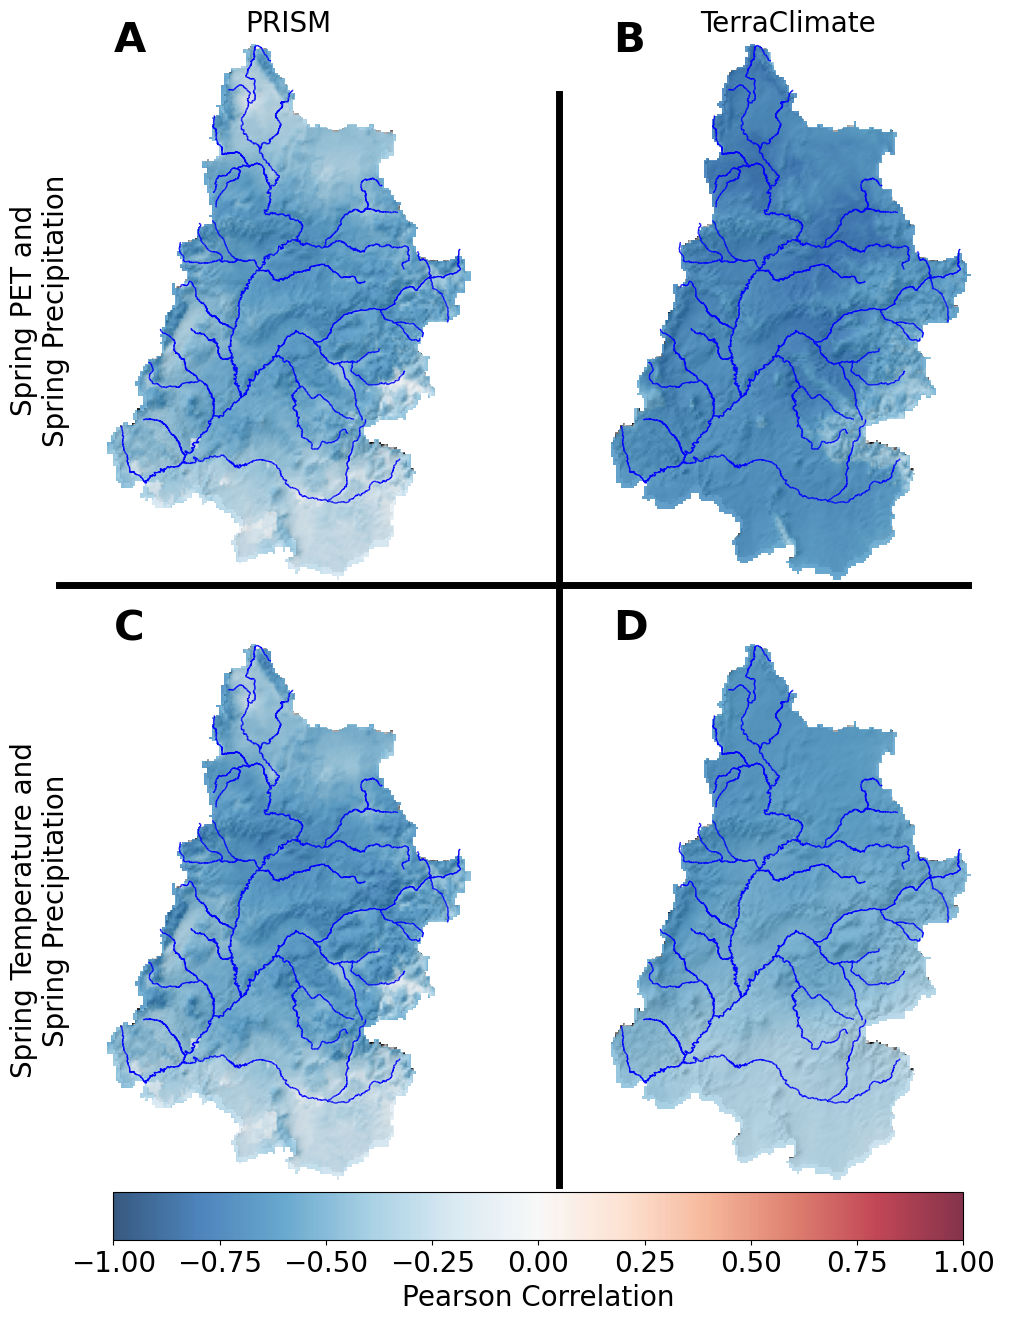

In [21]:
fig = plt.figure(figsize=(10, 12))
ax0 = plt.axes([0, 0, 1, 1])
ax0.set_xticks([])
ax0.set_yticks([])

ax1 = plt.axes([0.05, 0.55, 0.45, 0.45])

ax2 = plt.axes([0.55, 0.55, 0.45, 0.45])

ax3 = plt.axes([0.05, 0.05, 0.45, 0.45])

ax4 = plt.axes([0.55, 0.05, 0.45, 0.45])

ax0.plot([0.55, 0.55], [0,1], color='black', lw=5)
ax0.plot([0, 1], [0.55, 0.55], color='black', lw=5)
ax0.set_axis_off()

ax=ax1
# add another plot for the PRISM PET data
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
im = ax.imshow(corr_prism.values, alpha=0.8, cmap='RdBu_r', vmin=-1, vmax=1,extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
ax.set_axis_off()
# add title to axs[4]
ax.set_title('PRISM', size=20)
# add vertical text along the side of axs[0]
ax.text(-0.1, 0.5, 'Spring PET and\nSpring Precipitation', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, size=20)

ax=ax2
# add another plot for the TerraClimate PET data
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
im = ax.imshow(corr_terraclimate.values, alpha=0.8, cmap='RdBu_r', vmin=-1, vmax=1,extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
ax.set_axis_off()
# add title to axs[4]
ax.set_title('TerraClimate', size=20)

ax=ax3
# add another plot for the PRISM Temperature data
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
im = ax.imshow(corr_prism_temp.values, alpha=0.8, cmap='RdBu_r', vmin=-1, vmax=1,extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
ax.set_axis_off()

# add vertical text along the side of axs[0]
ax.text(-0.1, 0.5, 'Spring Temperature and\nSpring Precipitation', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, size=20)

ax=ax4
# add another plot for the TerraClimate Temperature data
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
im = ax.imshow(corr_terraclimate_temp.values, alpha=0.8, cmap='RdBu_r', vmin=-1, vmax=1,extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 

ax.axis('off')

# add title letters to upper left corner of each plot
ax0.text(0.1,0.99,'A',size=30,transform=ax0.transAxes, fontdict={'weight':'bold'})
ax0.text(0.6,0.99,'B',size=30,transform=ax0.transAxes, fontdict={'weight':'bold'})
ax0.text(0.1,0.5,'C',size=30,transform=ax0.transAxes, fontdict={'weight':'bold'})
ax0.text(0.6,0.5,'D',size=30,transform=ax0.transAxes, fontdict={'weight':'bold'})
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
# create horizontal colorbar
cbar_ax = fig.add_axes([0.1,0.00, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Pearson Correlation', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# fig.suptitle('Pearson Correlation Between Spring PET and Spring Precipitation\n1964-2022', size=24)
# add background whitespace
fig.patch.set_facecolor('white')

fig.savefig('../figures/pearson_correlation_spring_pet_spring_ppt.png', dpi=700, bbox_inches='tight')

# Compare PET and PPT products over spring
### Pull in nClimGrid

In [15]:
nclimgrid_ds = xr.open_dataset('../data/precipdata/nclimgrid_5km_ucrb.nc')
nclimgrid_ds = nclimgrid_ds.rio.write_crs(4326)
spring_nclimgrid_ds = nclimgrid_ds.where(nclimgrid_ds['time'].dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
spring_nclimgrid_ds = spring_nclimgrid_ds.where(spring_nclimgrid_ds>0,np.nan)
hcdn_spring_nclimgrid_ds = spring_nclimgrid_ds.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
hcdn_spring_nclimgrid_ds = hcdn_spring_nclimgrid_ds.where(hcdn_spring_nclimgrid_ds>0,np.nan)
hcdn_spring_ppt_nclimgrid_mean = hcdn_spring_nclimgrid_ds.mean(dim=['y','x']).sel(year=slice(1982,2013))
hcdn_spring_ppt_nclimgrid_mean_2 = hcdn_spring_nclimgrid_ds.mean(dim=['y','x']).sel(year=slice(1964,2022))

In [16]:
hcdn_boundaries = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_boundaries = hcdn_boundaries.set_crs(epsg=32613,allow_override=True)
hcdn_boundaries_4326 = hcdn_boundaries.to_crs(4326) # reprojection to 4326

In [17]:
# Grba PRISM spring data and clip to HCDN boundaries
ucrb_spring_ppt = prism_ppt.where(prism_ppt['month'].dt.month.isin([3,4,5]),drop=True).groupby('month.year').sum()
hcdn_spring_ppt_prism = ucrb_spring_ppt.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
hcdn_spring_ppt_prism = hcdn_spring_ppt_prism.where(hcdn_spring_ppt_prism>0,np.nan)
hcdn_spring_ppt_prism_mean = hcdn_spring_ppt_prism.mean(dim=['x','y']).sel(year=slice(1982,2013))
hcdn_spring_ppt_prism_mean_2 = hcdn_spring_ppt_prism.mean(dim=['x','y']).sel(year=slice(1964,2022))


### Pull in PET and ET from ERA5 and PPT from ERA5-Land

In [18]:
era5_et = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc')
era5_et = era5_et.rio.write_crs(4326)
era5_et = era5_et.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
# convert e and pev to mm/month from -1 * m/day by multiplying by days in each month
era5_et['month_days'] = era5_et.time.dt.days_in_month
era5_et['e'] = era5_et['e'] * era5_et['month_days'] * 1000 * -1
era5_et['pev'] = era5_et['pev'] * era5_et['month_days'] * 1000 * -1
# calculate the spring totals for each year
era5_et_spring = era5_et.where(era5_et.time.dt.month.isin([4,5,6]),drop=True).groupby('time.year').sum('time')
era5_et_spring['tcc'] = era5_et['tcc'].where(era5_et.time.dt.month.isin([4,5,6]),drop=True).groupby('time.year').mean('time')
# make zero values nan
era5_et_spring = era5_et_spring.where(era5_et_spring>0, np.nan)
# calculate spatial mean
era5_et_spring_mean = era5_et_spring.mean(dim=['latitude','longitude']).sel(year=slice(1964,2022))


In [19]:
era5_land_ds = xr.open_dataset('../data/precipdata/ERA5-land-monthly-1963-2022-UCRB.nc')
era5_land_ds = era5_land_ds.rio.write_crs(4326)
era5_land_ds = era5_land_ds.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)

# calculate the spring totals for each year
era5_land_spring = era5_land_ds.where(era5_land_ds.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
# make zero values nan
era5_land_spring = era5_land_spring.where(era5_land_spring>0, np.nan)
# calculate spatial mean    
hcdn_era5_land_spring_mean = era5_land_spring.mean(dim=['latitude','longitude']).sel(year=slice(1964,2022))


/tmp/ipykernel_889/3715437390.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


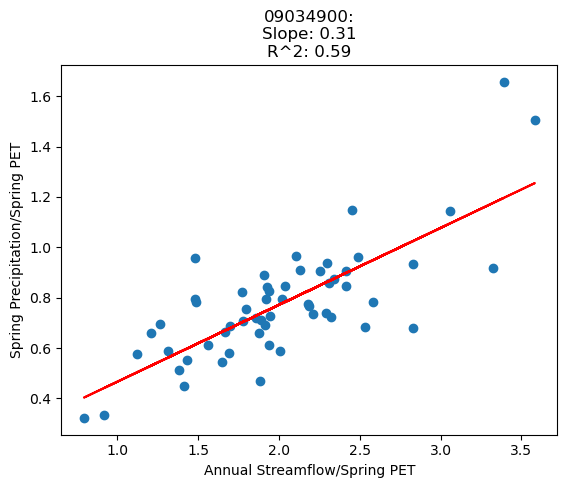

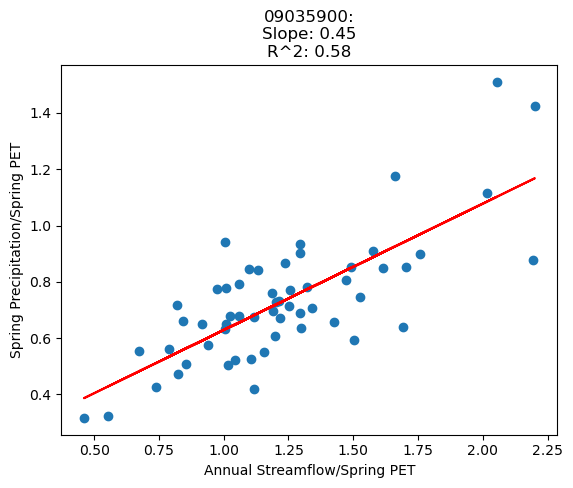

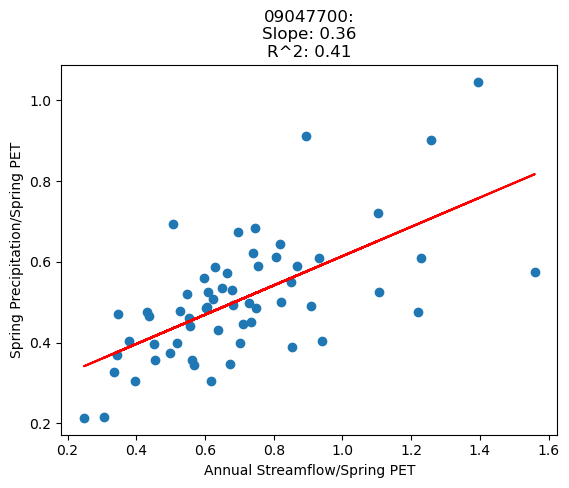

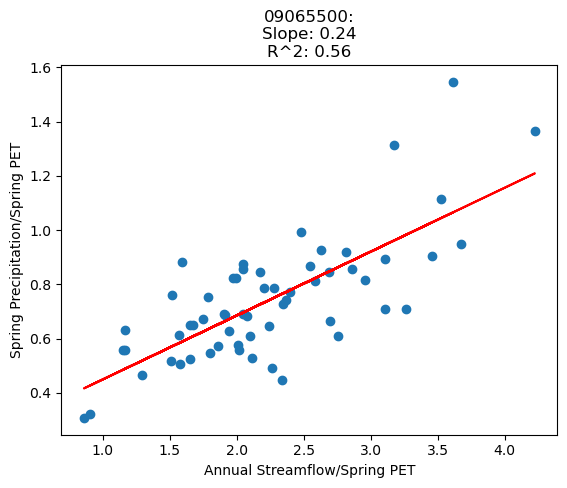

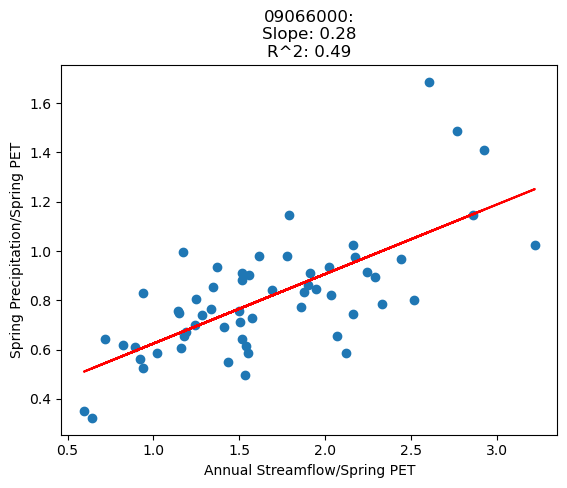

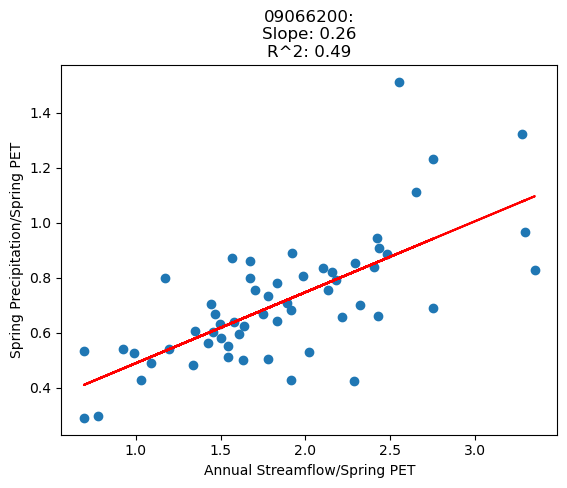

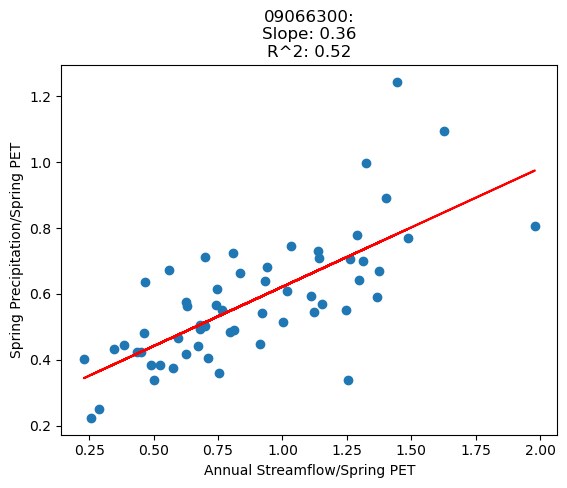

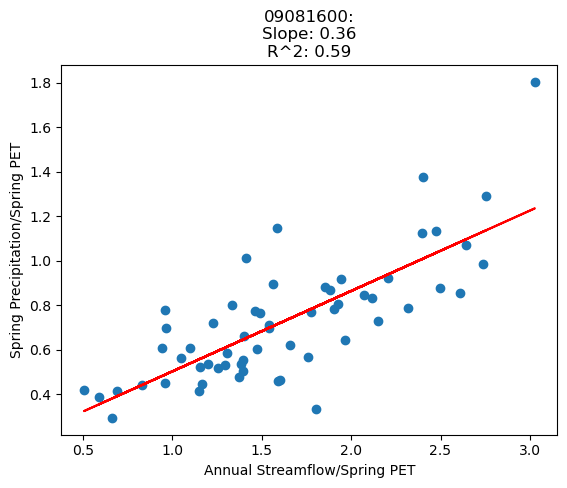

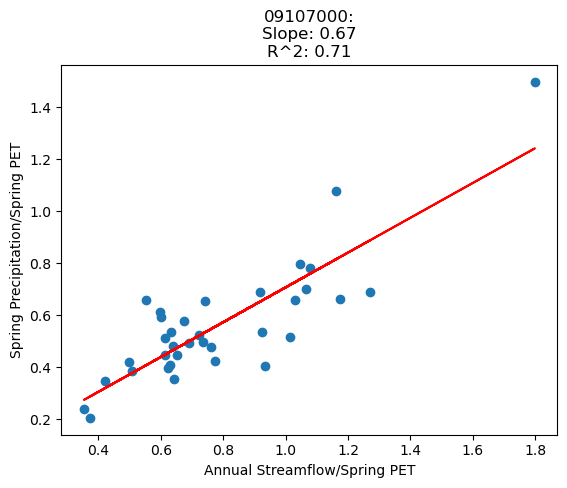

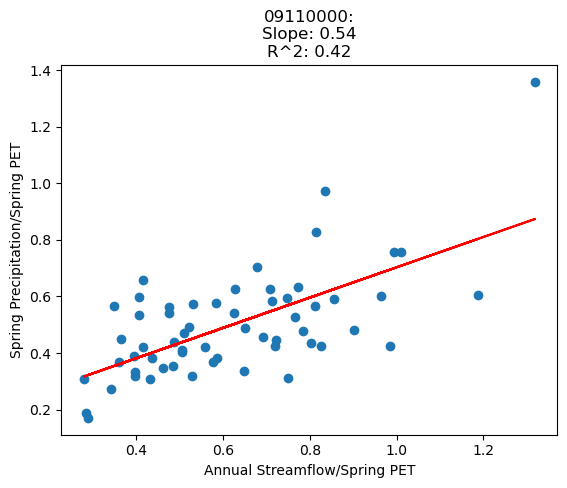

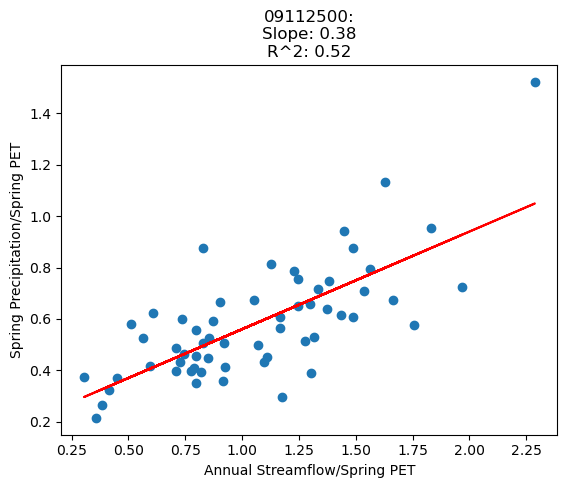

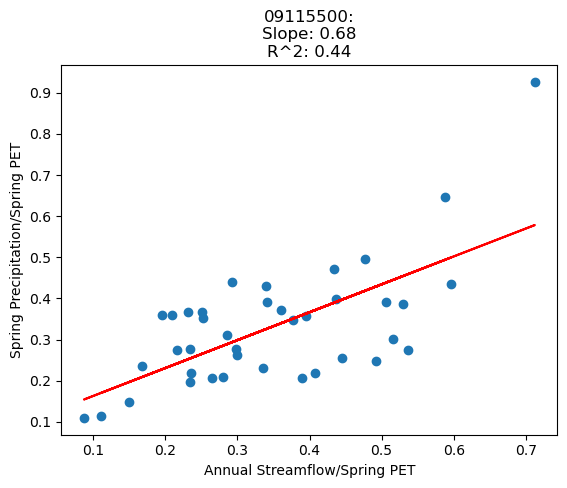

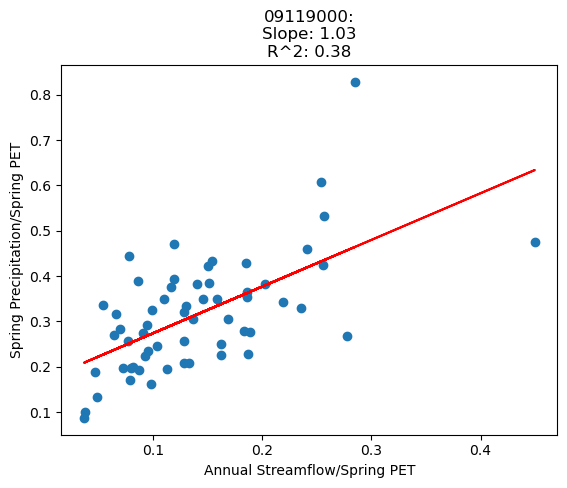

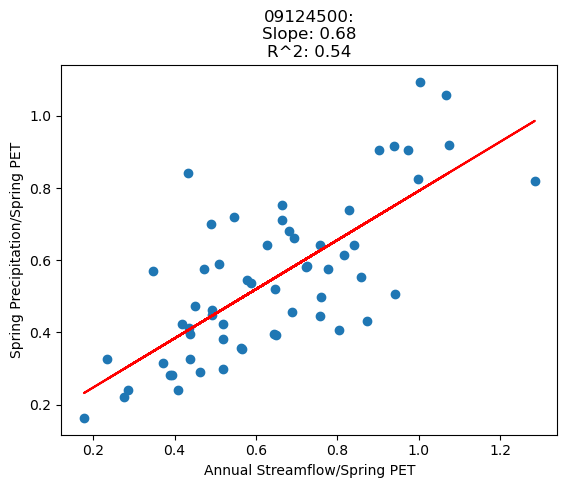

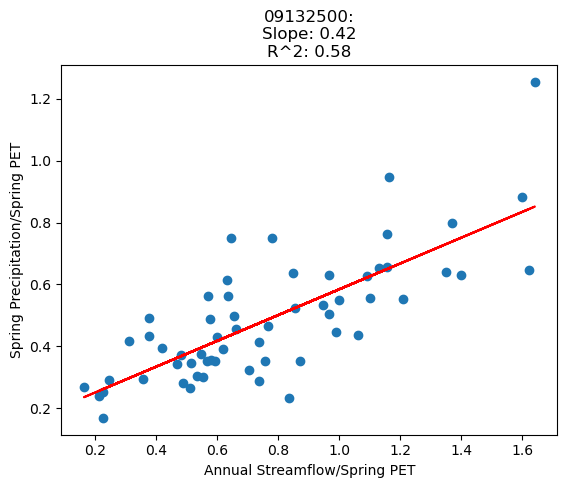

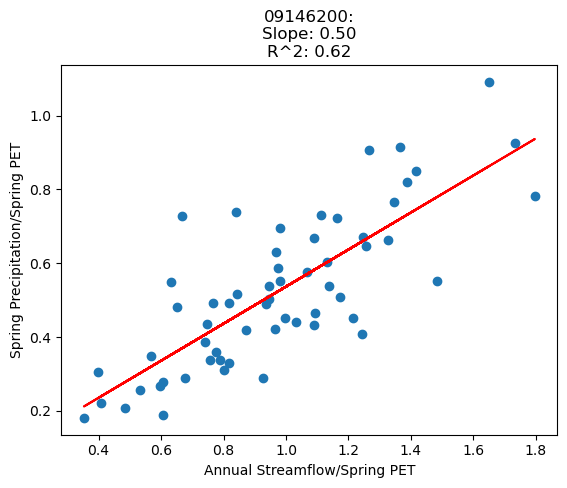

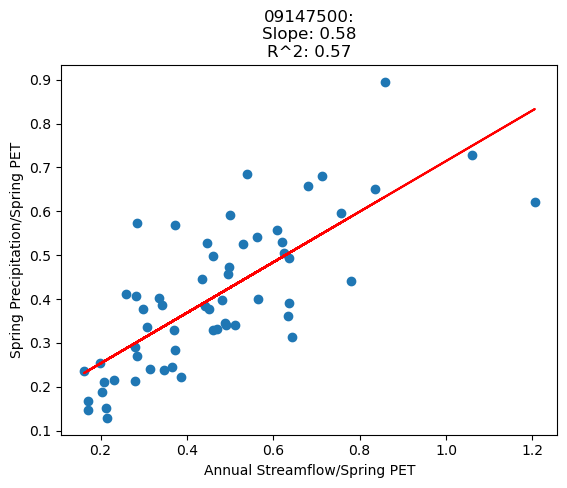

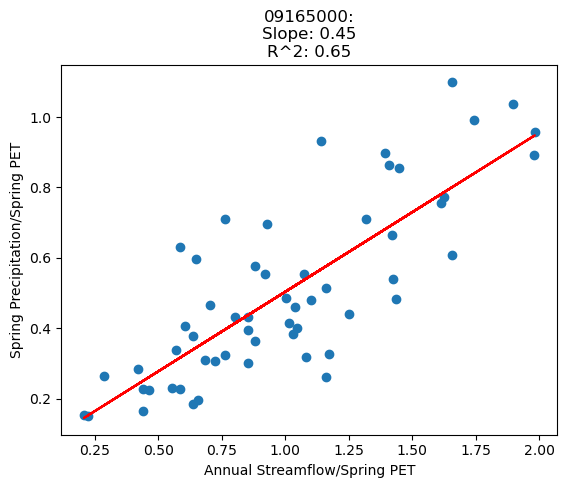

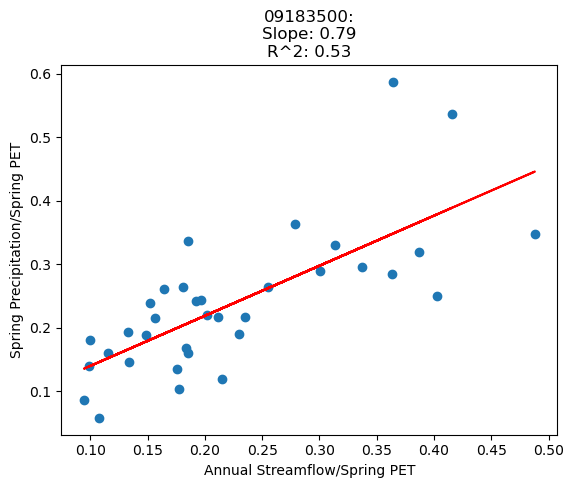

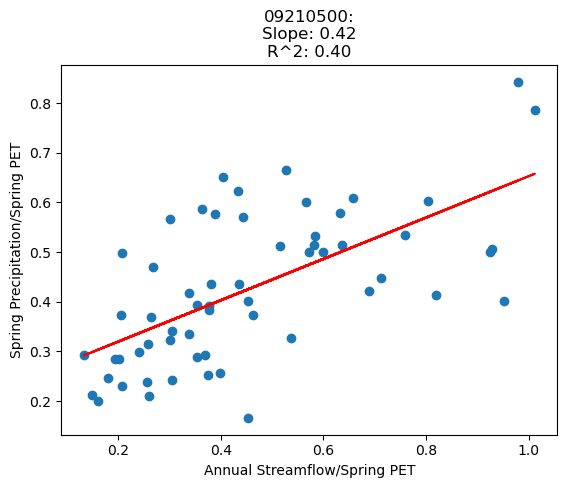

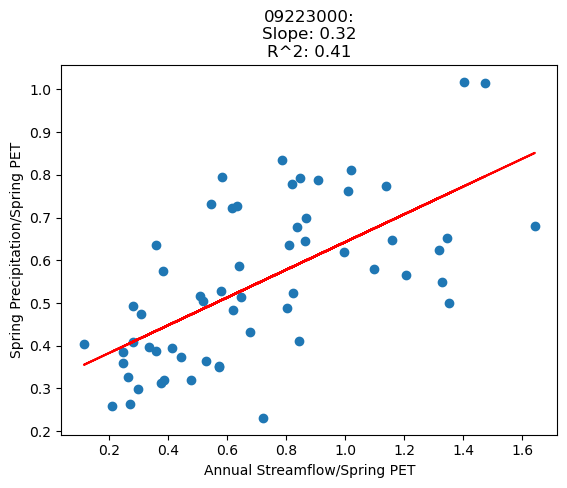

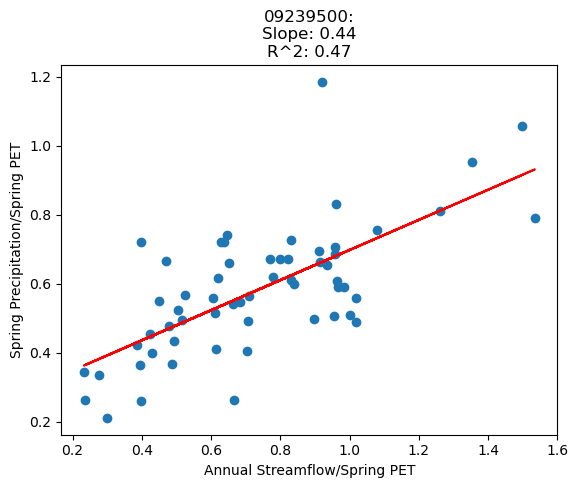

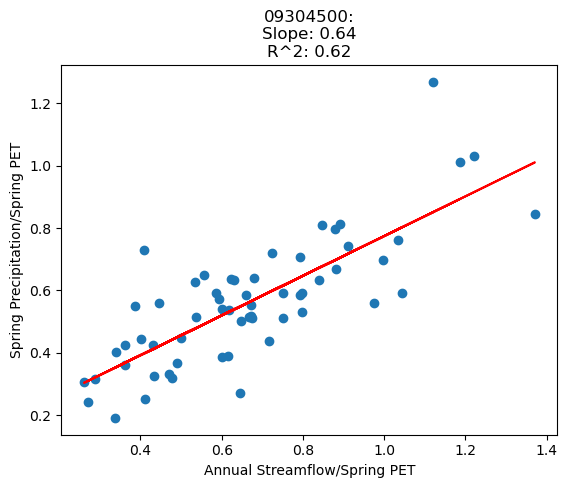

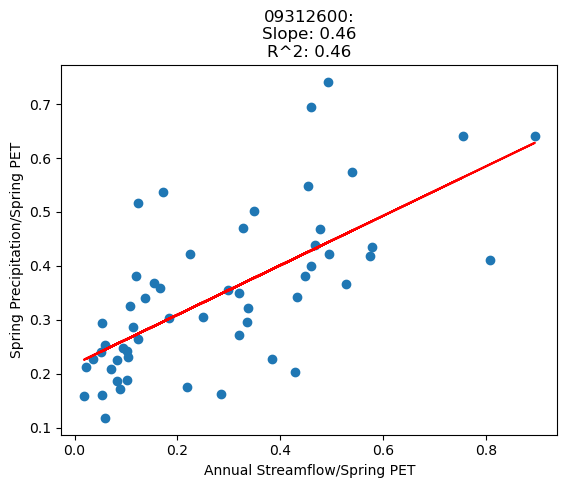

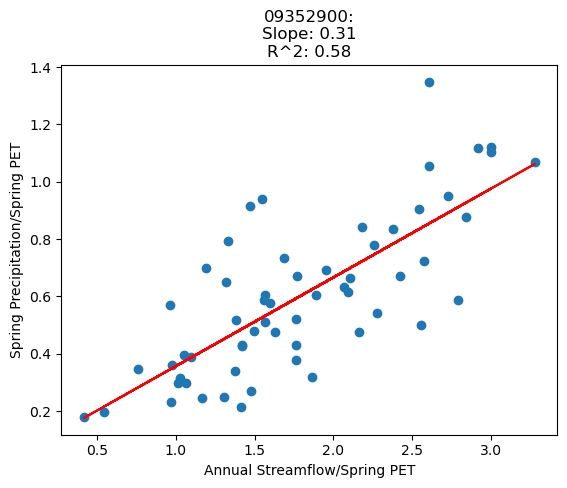

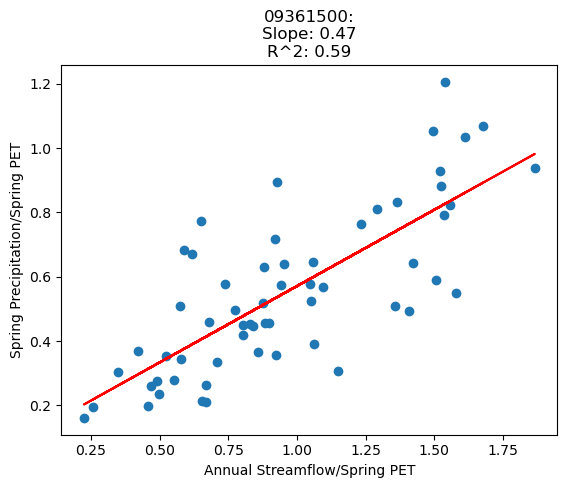

In [20]:
# example for looking at spring pet, spring p and streamflow
q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc')
r2 = []
for site in hcdn_boundaries_4326.gage:
    plt.figure()
    q_er = q.sel(site_no=site, WY=slice(1964,2022))
    p_er = hcdn_spring_nclimgrid_ds.rio.clip(hcdn_boundaries_4326[hcdn_boundaries_4326['gage']==site].geometry, all_touched=True).mean(dim=['x','y']).sel(year=slice(1964,2022))
    pet_er = era5_et_spring.rio.clip(hcdn_boundaries_4326[hcdn_boundaries_4326['gage']==site].geometry, all_touched=True).mean(dim=['latitude','longitude']).sel(year=slice(1964,2022)).pev
    q_pet_ratio = (q_er.q_mm.values/pet_er).dropna(dim='year')
    p_pet_ratio = (p_er.prcp/pet_er).sel(year=q_pet_ratio.year)
    plt.scatter(q_pet_ratio,
                p_pet_ratio)
    plt.xlabel('Annual Streamflow/Spring PET')
    plt.ylabel('Spring Precipitation/Spring PET')

    # find the slpoe and intercept of the linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(q_pet_ratio, p_pet_ratio)
    # plot the linear regression
    plt.plot((q_pet_ratio), slope*(q_pet_ratio) + intercept, color='red')
    plt.title(f'{site}:\n'+f'Slope: {slope:.2f}\nR^2: {r_value**2:.2f}')
    r2.append(r_value**2)


In [21]:
# Calculate OLS regression
X_prism = hcdn_spring_ppt_prism_mean_2.values
X_prism = sm.add_constant(X_prism)
Y_prism = era5_et_spring_mean['pev'].values

prism_model = sm.OLS(Y_prism,X_prism)
prism_res = prism_model.fit()
prism_res.conf_int()


array([[ 4.75964592e+02,  5.33945862e+02],
       [-6.53047221e-01, -3.69600275e-01]])

In [22]:
# Calculate OLS regression
X_nclimgrid = hcdn_spring_ppt_nclimgrid_mean_2.prcp.values
X_nclimgrid = sm.add_constant(X_nclimgrid)
Y_nclimgrid = era5_et_spring_mean['pev'].values

nclimgrid_model = sm.OLS(Y_nclimgrid,X_nclimgrid)
nclimgrid_res = nclimgrid_model.fit()
nclimgrid_res.conf_int()

array([[ 4.69670693e+02,  5.27948322e+02],
       [-6.50362712e-01, -3.53223601e-01]])

In [23]:
# Calculate OLS regression
X_era5 = hcdn_era5_land_spring_mean['tp'].values
X_era5 = sm.add_constant(X_era5)
Y_era5 = era5_et_spring_mean['pev'].values

era5_model = sm.OLS(Y_era5,X_era5)
era5_res = era5_model.fit()
era5_res.conf_int()

array([[ 4.87273064e+02,  5.51577371e+02],
       [-7.34175167e-01, -4.21215258e-01]])

In [24]:
total_cloud_cover = era5_et_spring_mean.tcc

In [25]:
# make a custom color ramp from dark grey to yellow
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["yellow","black"])

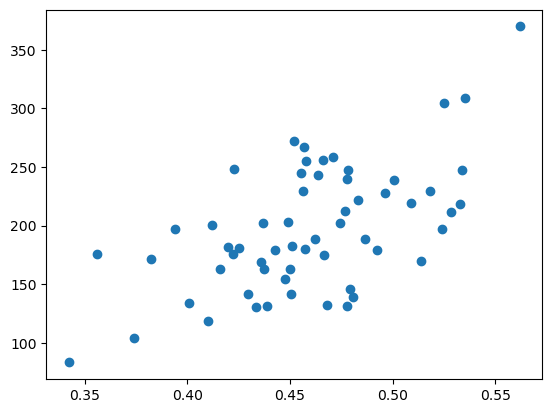

In [26]:
# plot cloud cover against hcdn spring precipiation
plt.figure()
plt.scatter(total_cloud_cover, hcdn_spring_ppt_prism_mean_2.values)

Text(0.5, 1.08, 'Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)')

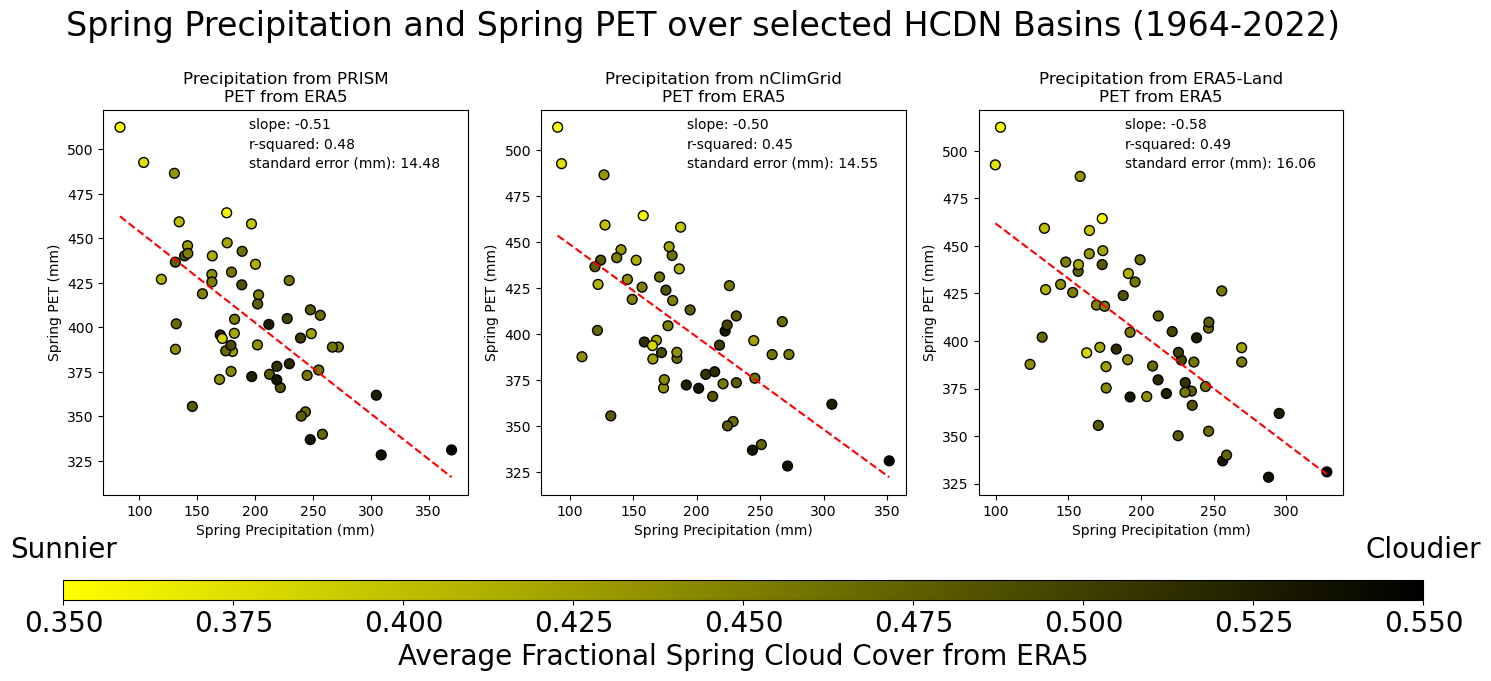

In [27]:
fig, axs = plt.subplots(ncols=3, figsize=(16,5))
ax = axs[0]
im=ax.scatter(hcdn_spring_ppt_prism_mean_2.values, 
           era5_et_spring_mean['pev'].values,
           c=total_cloud_cover.values,
           cmap=cmap,
           vmin=0.35,
           vmax=0.55,
           s=50,
           ec='k',)
# add a trend line from the ols model prism_results
ax.plot(np.sort(hcdn_spring_ppt_prism_mean_2.values), 
         prism_res.params[0]+prism_res.params[1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][0]+prism_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][1]+prism_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and standard error (mm)
ax.text(0.4,0.95,f'slope: {prism_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {prism_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {prism_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest prism_residual
residuals = Y_prism - prism_res.params[0] - prism_res.params[1]*X_prism[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from PRISM\nPET from ERA5')

# add a second plot for nclimgrid
ax = axs[1]
ax.scatter(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values,
           Y_nclimgrid,
           c=total_cloud_cover,
           cmap=cmap,
           vmin=0.35,
           vmax=0.55,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values), 
         nclimgrid_res.params[0]+nclimgrid_res.params[1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {nclimgrid_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {nclimgrid_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {nclimgrid_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_nclimgrid - nclimgrid_res.params[0] - nclimgrid_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from nClimGrid\nPET from ERA5')

# add a third plot for ERA5-Land
ax = axs[2]
ax.scatter(hcdn_era5_land_spring_mean['tp'].values, 
           Y_era5,
           c=total_cloud_cover,
           cmap=cmap,
           vmin=0.35,
           vmax=0.55,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_era5_land_spring_mean['tp'].values), 
         era5_res.params[0]+era5_res.params[1]*np.sort(hcdn_era5_land_spring_mean.tp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {era5_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {era5_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {era5_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_era5 - era5_res.params[0] - era5_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from ERA5-Land\nPET from ERA5')
# add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.1,-0.1, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Average Fractional Spring Cloud Cover from ERA5', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# add annotations from sunnier on the right side of the colorbar to cloudier on the left side
fig.text(0.1, 0.0, 'Sunnier', size=20, ha='center', va='center')
fig.text(0.95, 0.0, 'Cloudier', size=20, ha='center', va='center')

fig.suptitle('Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)', size=24, y=1.08)

### Pull in PET from CRU 
https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/cruts.2304141047.v4.07/pet/

In [292]:
cru_et = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_PET_1963_2022.nc')
# clip to HCDN boudnaries
hcdn_cru_et = cru_et.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
hcdn_cru_et = hcdn_cru_et.where(hcdn_cru_et>0,np.nan)
# calculate the mean spring PET for the HCDN basins
hcdn_spring_pet_cru = hcdn_cru_et.where(hcdn_cru_et['time'].dt.month.isin([4,5,6]),drop=True).groupby('time.year').sum('time')
hcdn_spring_pet_cru = hcdn_spring_pet_cru.where(hcdn_spring_pet_cru>0,np.nan)
# get the spatial mean of the spring PET for the HCDN basins
hcdn_spring_pet_cru_mean = hcdn_spring_pet_cru.mean(dim=['x','y']).sel(year=slice(1964,2022)).pet

Text(0, 0.5, 'ERA5 PET (mm)')

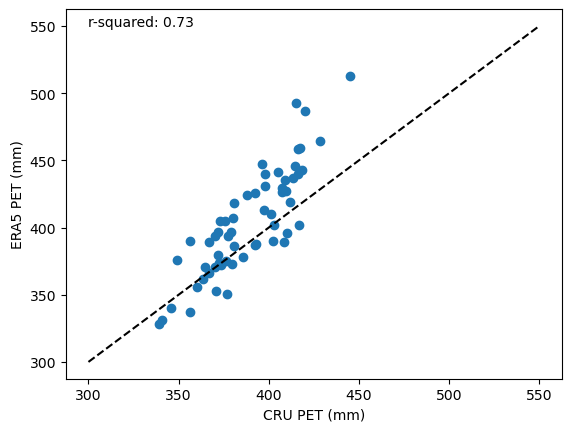

In [293]:
plt.scatter(hcdn_spring_pet_cru_mean.values,
            era5_et_spring_mean['pev'])
# plot 1-1 line
plt.plot([300, 550], [300, 550], 'k--')
# show r2 value
plt.text(300, 550, f'r-squared: {np.corrcoef(hcdn_spring_pet_cru_mean.values,era5_et_spring_mean["pev"].values)[0,1]**2:.2f}')
plt.xlabel('CRU PET (mm)')
plt.ylabel('ERA5 PET (mm)')

In [294]:
cru_tcc = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_tcc_1963_2022.nc')
# clip to HCDN boudnaries
hcdn_cru_tcc = cru_tcc.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)
# calculate the mean spring PET for the HCDN basins
hcdn_spring_tcc_cru = hcdn_cru_tcc.where(hcdn_cru_tcc['time'].dt.month.isin([4,5,6]),drop=True).groupby('time.year').mean(dim='time')
hcdn_spring_tcc_cru = hcdn_spring_tcc_cru.where(hcdn_spring_tcc_cru>0,np.nan)
# get the spatial mean of the spring PET for the HCDN basins
hcdn_spring_tcc_cru_mean = hcdn_spring_tcc_cru.mean(dim=['x','y']).sel(year=slice(1964,2022)).cld/100

In [295]:
# Calculate OLS regression
X_prism = hcdn_spring_ppt_prism_mean_2.values
X_prism = sm.add_constant(X_prism)
Y_prism = hcdn_spring_pet_cru_mean.values

prism_model = sm.OLS(Y_prism,X_prism)
prism_res = prism_model.fit()
prism_res.conf_int()


array([[ 4.31140030e+02,  4.62001652e+02],
       [-4.63669642e-01, -2.75048576e-01]])

In [296]:
# Calculate OLS regression
X_nclimgrid = hcdn_spring_ppt_nclimgrid_mean_2.prcp.values
X_nclimgrid = sm.add_constant(X_nclimgrid)
Y_nclimgrid = hcdn_spring_pet_cru_mean.values

nclimgrid_model = sm.OLS(Y_nclimgrid,X_nclimgrid)
nclimgrid_res = nclimgrid_model.fit()
nclimgrid_res.conf_int()

array([[ 4.27420148e+02,  4.59513238e+02],
       [-4.71005539e-01, -2.64735282e-01]])

In [297]:
# Calculate OLS regression
X_era5 = hcdn_era5_land_spring_mean['tp'].values
X_era5 = sm.add_constant(X_era5)
Y_era5 = hcdn_spring_pet_cru_mean.values

era5_model = sm.OLS(Y_era5,X_era5)
era5_res = era5_model.fit()
era5_res.conf_int()

array([[ 4.32319594e+02,  4.73699164e+02],
       [-4.86429967e-01, -2.54851785e-01]])

Text(0.5, 1.08, 'Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)')

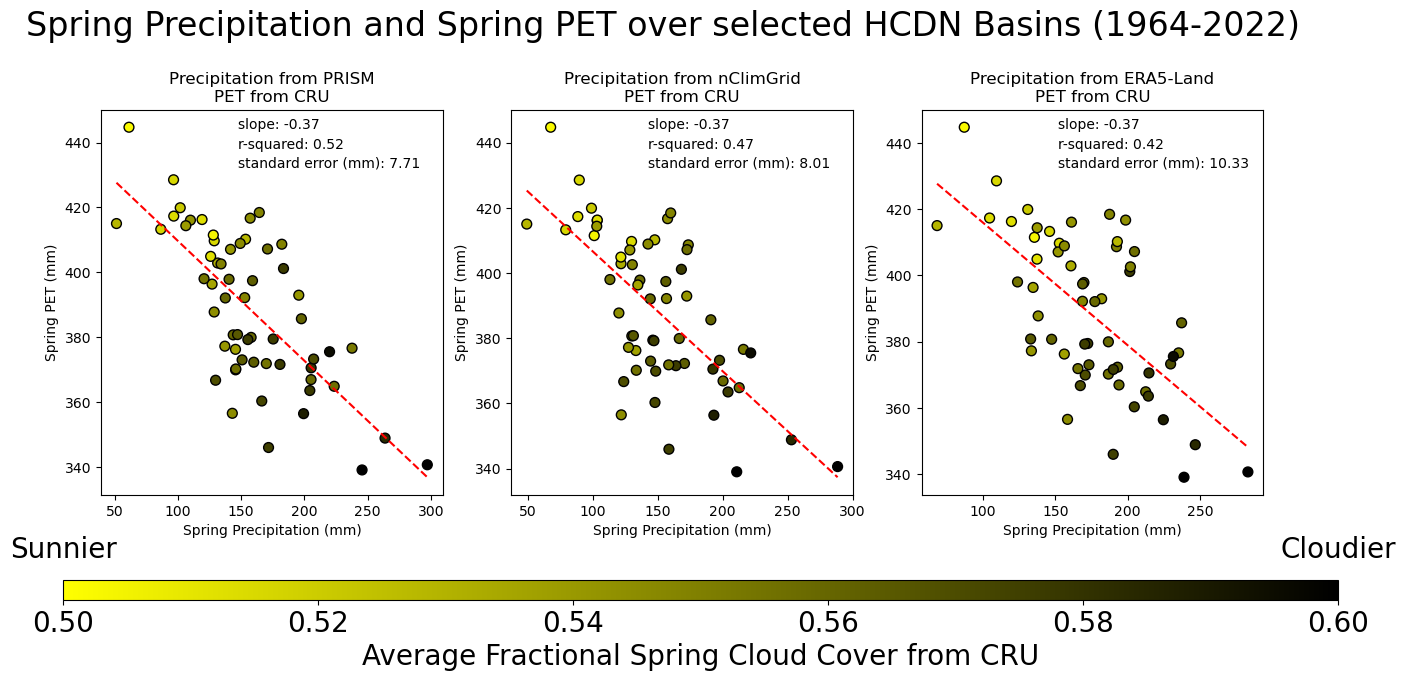

In [298]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
ax = axs[0]
im=ax.scatter(hcdn_spring_ppt_prism_mean_2.values, 
           hcdn_spring_pet_cru_mean.values,
           c=hcdn_spring_tcc_cru_mean,
           cmap=cmap,
           vmin=0.5,
           vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model prism_results
ax.plot(np.sort(hcdn_spring_ppt_prism_mean_2.values), 
         prism_res.params[0]+prism_res.params[1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][0]+prism_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  prism_res.conf_int()[0][1]+prism_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_prism_mean_2.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and standard error (mm)
ax.text(0.4,0.95,f'slope: {prism_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {prism_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {prism_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest prism_residual
residuals = Y_prism - prism_res.params[0] - prism_res.params[1]*X_prism[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from PRISM\nPET from CRU')

# add a second plot for nclimgrid
ax = axs[1]
ax.scatter(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values,
           Y_nclimgrid,
           c=hcdn_spring_tcc_cru_mean,
           cmap=cmap,
           vmin=0.5,
           vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values), 
         nclimgrid_res.params[0]+nclimgrid_res.params[1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {nclimgrid_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {nclimgrid_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {nclimgrid_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_nclimgrid - nclimgrid_res.params[0] - nclimgrid_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from nClimGrid\nPET from CRU')

# add a third plot for ERA5-Land
ax = axs[2]
ax.scatter(hcdn_era5_land_spring_mean['tp'].values, 
           Y_era5,
           c=hcdn_spring_tcc_cru_mean,
           cmap=cmap,
           vmin=0.5,
           vmax=0.6,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_era5_land_spring_mean['tp'].values), 
         era5_res.params[0]+era5_res.params[1]*np.sort(hcdn_era5_land_spring_mean.tp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean_2.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {era5_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {era5_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {era5_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_era5 - era5_res.params[0] - era5_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=era5_et_spring_mean.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.set_title('Precipitation from ERA5-Land\nPET from CRU')
# add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.1,-0.1, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Average Fractional Spring Cloud Cover from CRU', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# add annotations from sunnier on the right side of the colorbar to cloudier on the left side
fig.text(0.1, 0.0, 'Sunnier', size=20, ha='center', va='center')
fig.text(0.95, 0.0, 'Cloudier', size=20, ha='center', va='center')

fig.suptitle('Spring Precipitation and Spring PET over selected HCDN Basins (1964-2022)', size=24, y=1.08)

### Pull in P-LSH ET data

In [299]:
dates = pd.date_range(start='1982-1-1',end='2013-12-31',freq='M')
p_lsh_et = xr.open_mfdataset('../data/etdata/P-LSH_ET/UCRB_Monthly_ET_*.nc',concat_dim='time',combine='nested')
# drop spatial_ref
p_lsh_et['time'] = dates
# add crs
p_lsh_et = p_lsh_et.rio.write_crs(4326)
# clip to HCDN boundaries
p_lsh_et = p_lsh_et.rio.clip(hcdn_boundaries_4326.geometry, all_touched=True)

In [300]:
# calculate the spring totals for each year
p_lsh_et_spring = p_lsh_et.where(p_lsh_et.time.dt.month.isin([4,5,6]),drop=True).groupby('time.year').sum('time')
# make zero values nan
p_lsh_et_spring = p_lsh_et_spring.where(p_lsh_et_spring>0, np.nan)


In [301]:
# Calculate OLS regression
X_prism = hcdn_spring_ppt_prism_mean.values
X_prism = sm.add_constant(X_prism)
Y_prism = p_lsh_et_spring['monthly_ET'].mean(dim=['LAT','LON']).compute().values

prism_model = sm.OLS(Y_prism,X_prism)
prism_res = prism_model.fit()
prism_res.conf_int()


array([[ 2.48925176e+02,  2.83635659e+02],
       [-3.72978603e-01, -1.68940757e-01]])

In [302]:
# Calculate OLS regression
X_nclimgrid = hcdn_spring_ppt_nclimgrid_mean.prcp.values
X_nclimgrid = sm.add_constant(X_nclimgrid)
Y_nclimgrid = p_lsh_et_spring['monthly_ET'].mean(dim=['LAT','LON']).compute().values

nclimgrid_model = sm.OLS(Y_nclimgrid,X_nclimgrid)
nclimgrid_res = nclimgrid_model.fit()
nclimgrid_res.conf_int()

array([[ 2.45698249e+02,  2.82522780e+02],
       [-3.85418545e-01, -1.57189545e-01]])

In [303]:
total_cloud_cover_2 = total_cloud_cover.sel(year=slice(1982,2013))

Text(0.5, 1.08, 'Spring Precipitation and Spring PET over selected HCDN Basins (1982-2013)')

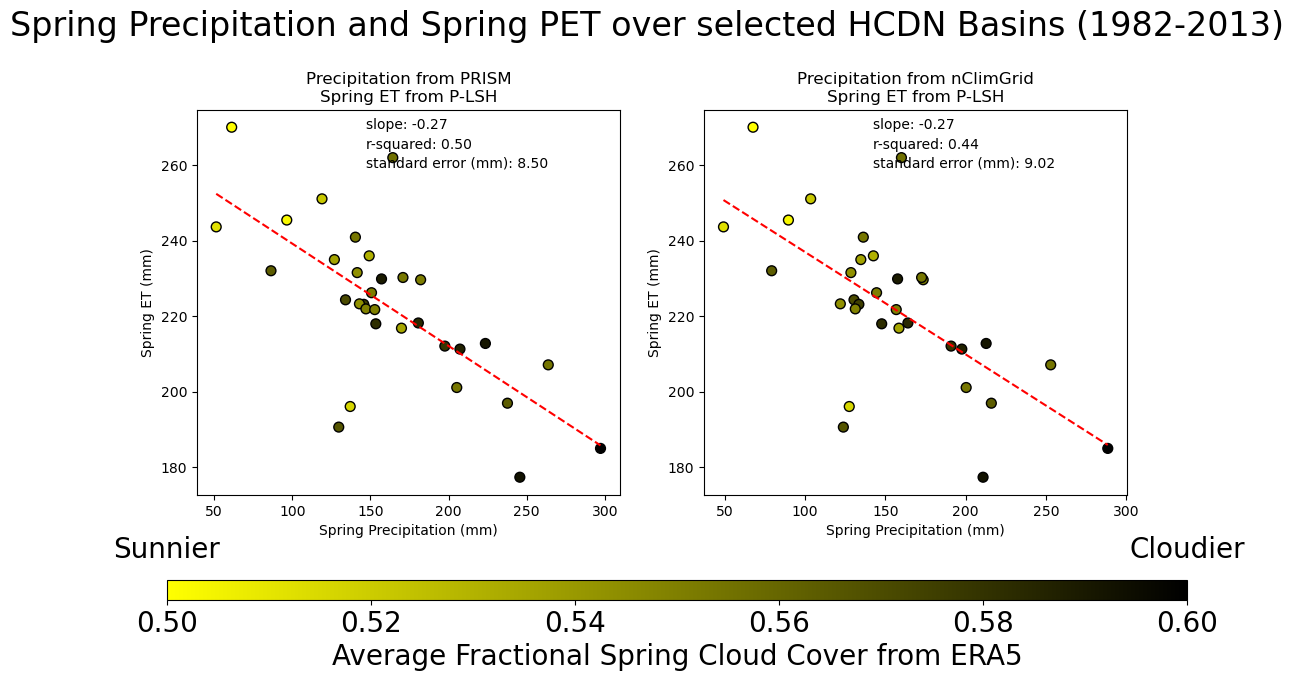

In [304]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
ax = axs[0]
ax.scatter(hcdn_spring_ppt_prism_mean.values, 
           p_lsh_et_spring['monthly_ET'].mean(dim=['LAT','LON']).compute().values,
           c=total_cloud_cover_2,
           cmap=cmap,
           vmin=0.35,
           vmax=0.55,
           s=50,
           ec='k',)
# add a trend line from the ols model prism_results
ax.plot(np.sort(hcdn_spring_ppt_prism_mean.values), 
         prism_res.params[0]+prism_res.params[1]*np.sort(hcdn_spring_ppt_prism_mean.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_prism_mean.values),
#                  prism_res.conf_int()[0][0]+prism_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_prism_mean.values),
#                  prism_res.conf_int()[0][1]+prism_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_prism_mean.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and standard error (mm)
ax.text(0.4,0.95,f'slope: {prism_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {prism_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {prism_res.bse[0]:.2f}',transform=ax.transAxes)

# find years with largest prism_residual
residuals = Y_prism - prism_res.params[0] - prism_res.params[1]*X_prism[:,1]
residuals = pd.Series(residuals,index=p_lsh_et_spring.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring ET (mm)')
ax.set_title('Precipitation from PRISM\nSpring ET from P-LSH')

# add a second plot for nclimgrid
ax = axs[1]
ax.scatter(hcdn_spring_ppt_nclimgrid_mean.prcp.values, 
           Y_nclimgrid,
           c=total_cloud_cover_2,
           cmap=cmap,
           vmin=0.35,
           vmax=0.55,
           s=50,
           ec='k',)
# add a trend line from the ols model nclimgrid_results
ax.plot(np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values), 
         nclimgrid_res.params[0]+nclimgrid_res.params[1]*np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values),
         color='red',
         ls='--')
# # plot the 95th confidence interval
# ax.fill_between(np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values),
#                  nclimgrid_res.conf_int()[0][0]+nclimgrid_res.conf_int()[1][0]*np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values),
#                  nclimgrid_res.conf_int()[0][1]+nclimgrid_res.conf_int()[1][1]*np.sort(hcdn_spring_ppt_nclimgrid_mean.prcp.values),
#                  color='red',
#                  alpha=0.2)
# add text for the slope, r-squared, and p-value
ax.text(0.4,0.95,f'slope: {nclimgrid_res.params[1]:.2f}',transform=ax.transAxes)
ax.text(0.4,0.90,f'r-squared: {nclimgrid_res.rsquared:.2f}',transform=ax.transAxes)
ax.text(0.4,0.85,f'standard error (mm): {nclimgrid_res.bse[0]:.2f}',transform=ax.transAxes)
# find years with largest nclimgrid_residual
residuals = Y_nclimgrid - nclimgrid_res.params[0] - nclimgrid_res.params[1]*X_nclimgrid[:,1]
residuals = pd.Series(residuals,index=p_lsh_et_spring.year.values)
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('Spring ET (mm)')
ax.set_title('Precipitation from nClimGrid\nSpring ET from P-LSH')
# add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.1,-0.1, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Average Fractional Spring Cloud Cover from ERA5', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# add annotations from sunnier on the right side of the colorbar to cloudier on the left side
fig.text(0.1, 0.0, 'Sunnier', size=20, ha='center', va='center')
fig.text(0.95, 0.0, 'Cloudier', size=20, ha='center', va='center')

fig.suptitle('Spring Precipitation and Spring PET over selected HCDN Basins (1982-2013)', size=24, y=1.08)

# <a id='toc6_'></a>[Plot PET against Spring P colored by Tmean](#toc0_)

### <a id='toc6_1_1_'></a>[Assessing temporal trend in temperature vs. spring preciptiation relationship](#toc0_)

In [34]:
prism_spring_temp_anomaly = spring_mean_ucrb_temp_anomaly.mean(dim=['x','y'])
prism_spring_ppt = ucrb_spring_ppt.where(ucrb_spring_ppt>0).mean(dim=['x','y'])

0.004134244586688366
0.008174596497408398


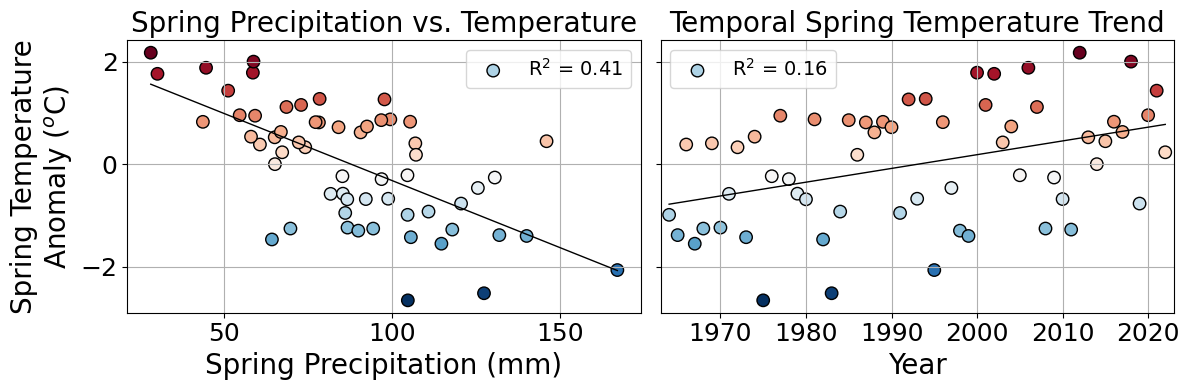

In [35]:
fig, axs = plt.subplots(ncols=2,figsize=(12,4), sharey=True, tight_layout=True)
years_of_interest=slice(1958,2022)
ax=axs[0]
# add an r2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(prism_spring_ppt.sel(year=years_of_interest),prism_spring_temp_anomaly.sel(year=years_of_interest))
print(std_err)
ax.scatter(prism_spring_ppt.sel(year=years_of_interest),prism_spring_temp_anomaly.sel(year=years_of_interest),
           c=prism_spring_temp_anomaly.sel(year=years_of_interest),
           cmap='RdBu_r', 
           ec='k',
           s=80,
           label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
x = prism_spring_ppt.sel(year=years_of_interest).sortby(prism_spring_ppt.sel(year=years_of_interest))
y_predicted = slope*x + intercept
ax.plot(x, y_predicted, '-', color='k', linewidth=1)
ax.legend(fontsize=14)
ax.set_ylabel('Spring Temperature\nAnomaly ($^o$C)',size=20)
ax.set_xlabel('Spring Precipitation (mm)',size=20)
ax.set_title('Spring Precipitation vs. Temperature',size=20)
ax.grid()

ax=axs[1]
# add an r2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(prism_spring_temp_anomaly.sel(year=years_of_interest).year,
                                                               prism_spring_temp_anomaly.sel(year=years_of_interest))
print(std_err)
ax.scatter(prism_spring_temp_anomaly.sel(year=years_of_interest).year,
           prism_spring_temp_anomaly.sel(year=years_of_interest), 
           c=prism_spring_temp_anomaly.sel(year=years_of_interest),
           cmap='RdBu_r', 
           ec='k',
           s=80,
           label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
x = prism_spring_temp_anomaly.sel(year=years_of_interest).year.sel(year=slice(1964,2022)) 
y_predicted = slope*x + intercept
ax.plot(x, y_predicted, '-', color='k', linewidth=1)
ax.legend(fontsize=14)
ax.set_xlabel('Year',size=20)
# ax.set_ylabel('Spring Mean Temperature Anomaly (C)',size=20)
ax.set_title('Temporal Spring Temperature Trend',size=20)
ax.set_xlim(1963,2023)
# increase the ticklabel size for x and y axes
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=18)
# add A and B to the upper left corner of each axes
# axs[0].text(-0.05,1.05,'A',size=30,transform=axs[0].transAxes, fontdict={'weight':'bold'})
# axs[1].text(0.00,1.05,'B',size=30,transform=axs[1].transAxes, fontdict={'weight':'bold'})
# Set facecolor to white
fig.patch.set_facecolor('white')
ax.grid()
# add figure y axis label 
# fig.text(-0.02, 0.5, 'Spring Temperature Anomaly (C)', va='center', rotation='vertical', fontsize=20)

### <a id='toc6_1_2_'></a>[Assessing temporal trend in PET vs. spring precipitation relationship](#toc0_)

In [39]:
prism_spring_pet = ucrb_prism_pet.where(ucrb_prism_pet['month'].dt.month.isin([4,5,6]),drop=True).groupby('month.year').sum()
# take spatial mean
prism_spring_pet = prism_spring_pet.mean(dim=['y','x'])

spring_totals_terraclime_pet = ucrb_spring_totals_terraclime_pet.where(ucrb_spring_totals_terraclime_pet>0).mean(dim=['lat','lon'])
spring_totals_terraclime_ppt = ucrb_spring_totals_terraclime_ppt.where(ucrb_spring_totals_terraclime_ppt>0).mean(dim=['lat','lon'])

0.03769853186393931
0.03464735646018899


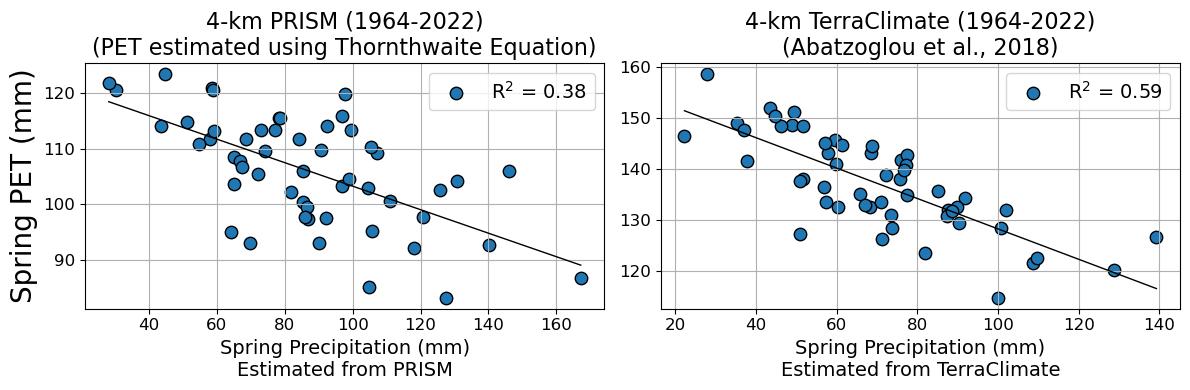

In [40]:
spring_totals_terraclime_pet_corrected = spring_totals_terraclime_pet/3
fig, axs = plt.subplots(ncols=2,figsize=(12,4),  tight_layout=True)
years_of_interest=slice(1970,2022)
ax=axs[0]
# add an r2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(prism_spring_ppt.sel(year=years_of_interest),prism_spring_pet.sel(year=years_of_interest))
print(std_err)
ax.scatter(prism_spring_ppt.sel(year=years_of_interest),prism_spring_pet.sel(year=years_of_interest),
        #    c=spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest),
        #    cmap='RdBu_r', 
           ec='k',
           s=80,
           label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
x = prism_spring_ppt.sel(year=years_of_interest).sortby(prism_spring_ppt.sel(year=years_of_interest))
y_predicted = slope*x + intercept
ax.plot(x, y_predicted, '-', color='k', linewidth=1)
ax.legend(fontsize=14)
ax.set_ylabel('Spring PET (mm)',size=20)
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_xlabel('Spring Precipitation (mm)\nEstimated from PRISM',fontsize=14)
# ax.set_ylabel('Spring PET (Thornthwaite) (mm)',fontsize=14)
ax.set_title('4-km PRISM (1964-2022)\n(PET estimated using Thornthwaite Equation)',fontsize=16)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)
ax.grid(zorder=10)


ax = axs[1]
slope, intercept, r_value, p_value, std_err = stats.linregress(spring_totals_terraclime_ppt.sel(year=years_of_interest),spring_totals_terraclime_pet_corrected.sel(year=years_of_interest))
print(std_err)
ax.scatter(spring_totals_terraclime_ppt.sel(year=years_of_interest),spring_totals_terraclime_pet_corrected.sel(year=years_of_interest),
        #    c=spring_tmean_terraclime_anomaly.sel(year=years_of_interest),
        #    cmap='RdBu_r', 
           ec='k',
           s=80,
           label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
x = spring_totals_terraclime_ppt.sel(year=years_of_interest).sortby(spring_totals_terraclime_ppt.sel(year=years_of_interest))
y_predicted = slope*x + intercept
ax.plot(x, y_predicted, '-', color='k', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)
ax.set_title('4-km TerraClimate (1964-2022)\n(Abatzoglou et al., 2018)',fontsize=16)
ax.set_xlabel('Spring Precipitation (mm)\nEstimated from TerraClimate',fontsize=14)
ax.grid(zorder=10)